## Tutorial A4: Seqlets

> deep_lift_shap/saturation mutagenesis

Ultimately, our goal is to better understand the genomic sequences driving biological activity. To do this, we train machine learning models to make accurate predictions and then we use attribution methods (DeepLIFT/SHAP, in silico saturation mutagenesis, whatever) to highlight the individual nucleotides driving those model predictions. However, simply assigning some weight to each nucleotide is not particularly informative, nor is it a scalable way to understand what a model has learned.

Accordingly, after calculating attribution scores, a common task is to identify the contiguous *spans* of high attribution characters that drive model predictions and, potentially, form protein binding sites. These spans are called "seqlets" and form the basis of subsequent algorithms that aim to distill what these machine learning methods have learned. For example, seqlets can be clustered into recurring patterns that drive model predictions (e.g., as TF-MoDISco does), but seqlets can also be used as an automated way of annotating sequences and extracting spatial relationships between motifs. At a high level, one can think of a seqlet as a base cis-regulatory unit identified by the model.

Like with our other tutorials, let's begin by loading the Beluga model.

In [1]:
import torch
from model import Beluga

model = Beluga()
model.load_state_dict(torch.load("deepsea.beluga.torch"))

<All keys matched successfully>

To demonstrate seqlet calling, we need clean attribution scores. In practice, one will usually run a seqlet caller on attributions from real genomic sequences. However, for demonstration purposes, we will randomly generate a sequence and insert three known motifs into it. Specifically, we will insert two identical AP-1 motifs and a YY-1 motif, at equal spacings from each other. Then, we will run DeepLIFT/SHAP using a DNase target.

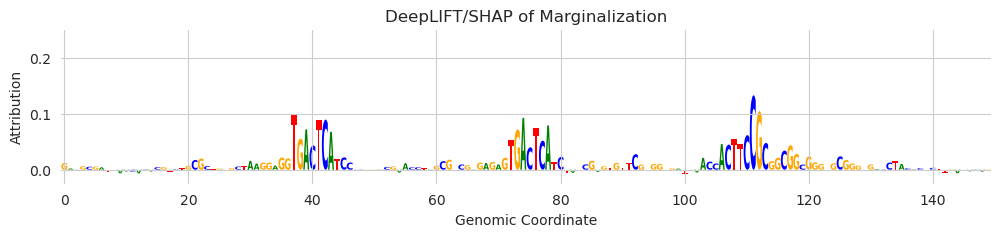

In [2]:
from matplotlib import pyplot as plt
import seaborn; seaborn.set_style('whitegrid')

from tangermeme.utils import random_one_hot
from tangermeme.ersatz import multisubstitute
from tangermeme.deep_lift_shap import deep_lift_shap
from tangermeme.plot import plot_logo

X = random_one_hot((1, 4, 2000), random_state=0).type(torch.float32)  
X = multisubstitute(X, ["GTGACTCATC", "GTGACTCATC", "ACTTCCGCG"], [25, 25])
X_attr = deep_lift_shap(model, X, device='cpu', n_shuffles=20, target=57, random_state=0)

plt.figure(figsize=(12, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0, :, 925:1075], ax=ax)
plt.ylim(-0.025, 0.25)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

Looks like the two AP-1 motifs are being pulled out neatly and the YY1 motif is a bit less clean. Hopefully, a seqlet caller will be able to identify all three patterns based on being much 

##### Recursive Seqlets

A new seqlet calling algorithm implemented in tangermeme is the "recursive seqlet" caller. This method is meant to be a simplification -- both conceptually and implementation-wise -- on the seqlet calling algorithm used in TF-MoDISco. Conceptually, it works by first constructing a background distribution of attribution scores for all span lengths (between user-specified parameters) and then scoring all potential spans according to these background distributions. This process results in a `(n_lengths, sequence_length)` matrix of p-values. 

There are several ways that one could decode this matrix to get actual seqlets, many of which introduce several new parameters that would need to be optimized, but the recursive algorithm relies on a simple definition: a seqlet is the longest span whose p-value is below a threshold where *all* internal spans *also* are below the p-value threshold. This gives a precise meaning to what a seqlet actually is and also circumvents several problems that can arise in decoding with other definitions, e.g., the flanks can be too long when you say a seqlet is simply the longest span below a threshold if there's a central core that has really high attributions.

This definition results in a method that has very few parameters and is quite fast. Let's see it in action.

In [3]:
from tangermeme.seqlet import recursive_seqlets

seqlets = recursive_seqlets(X_attr.sum(dim=1))
seqlets

,example_idx,start,end,attribution,p-value
1,0,1578,1583,-0.024013,4.662937e-15
0,0,1033,1039,0.446336,4.798464e-03
2,0,932,937,-0.020814,5.285412e-03
3,0,962,967,0.357937,6.717850e-03
4,0,998,1002,0.278854,8.579600e-03


Note that the function is run on the the attributions corresponding to the observed characters and so is only two dimensions (with the dimensions being the examples and the other being the length of the examples). A dataframe is returned that is mostly BED formatted, with the first column being the index of the example and the second and third columns being the start and end of the seqlet call, respectively. The attributions are the sum of the attribution across the seqlet and the p-value is the value of the seqlet (at that position and at that length). The recursive property means that all internal spans must also have a p-value lower than the threshold, but those values do not affect the p-value of the seqlet returned here.

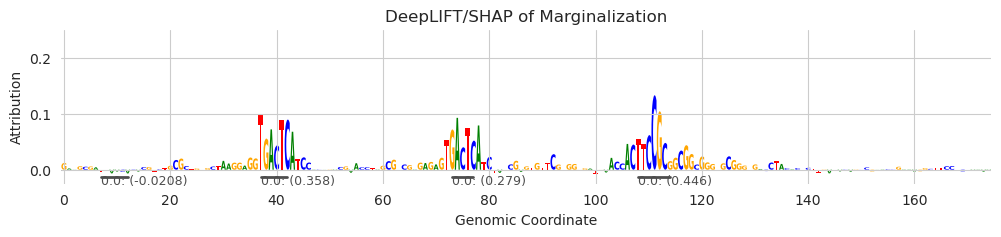

In [4]:
plt.figure(figsize=(12, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=925, end=1100, annotations=seqlets, score_key='attribution')
plt.ylim(-0.025, 0.25)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

This example encapsulates the strengths and weaknesses of the recursive seqlet function. Starting with the strengths: it looks like it captured all three motifs, and did so quickly and with only one example to build background distributions with. No other false-positive seqlets were called. Further, it called only a total of five seqlets in the entire sequence, with the other seqlets being two low-attribution negative seqlets. As for weaknesses, it looks like it called two negative seqlets with very low attribution value and the spans for all the seqlets are relatively conservative. The negative seqlet calls are likely an artifact of having to construct background distributions for negative seqlets using only a single example where most spans have positive attributions, so a huge dirth of data. When calling seqlets using more examples, this issue should resolve, but one could get around this issue by making sure that the magnitude of the seqlet attributions is above some threshold.

As for having conservative boundaries... this is a consequence of the recursive seqlet property and the noise in the data. If too many characters have low attribution in a row -- or even negative attributions -- the recursive property may not hold for the shorter spans. Further, calling significant seqlets is going to require good background distributions of attribution values. A single example may not have enough examples of background distributions of all attribution strengths and also for all span lengths. I would expect that this has a saturation property, where having more examples provides a significant boost in seqlet boundary expansion until a certain point where it levels off. 

The reasoning for focusing on finding the cores of seqlets and maybe missing some of the flanks is that seqlet calling is very imprecise and subjective. Where exactly does the YY1 seqlet on the right begin and end? Does it include the `GCGGG` toward the end? What about the subsequent `CTA`? In principle, this can be resolved by clustering together YY1 seqlets to find consensus patterns (as TF-MoDISCo does) but when just calling seqlets with no other information, the exact borders can be difficult to define.

So, if one views the recursive seqlet algorithm as good at finding cores of seqlets and maybe needs additional flanks on either side -- or maybe you are in a setting where you need the surrounding context of the seqlet for your downstream application -- we can expand the flanks of the seqlet with the `additional_flanks` parameter.

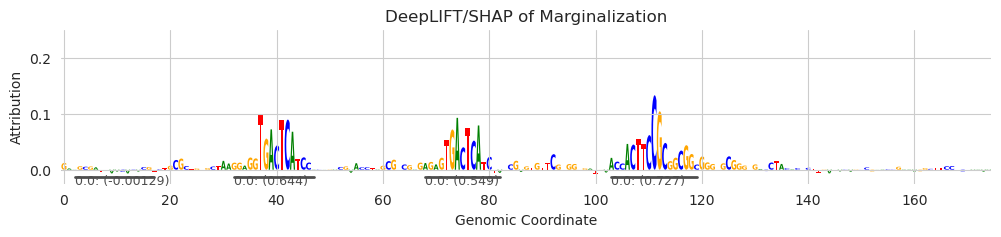

In [5]:
seqlets = recursive_seqlets(X_attr.sum(dim=1), additional_flanks=5)

plt.figure(figsize=(12, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=925, end=1100, annotations=seqlets, score_key='attribution')
plt.ylim(-0.025, 0.25)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

Here, all we are doing is setting the start and end of the seqlet to have an offset of 5 more than the original call. It looks like the calls may be much better for most purposes, especially for ones where it is okay to have some uninformative positions on either end. Adding additional flanks does not affect the seqlet calling procedure and it does not influence the returned attribution score or the p-values, which remain for the original span. Further, seqlet calls cannot overlap each other, but the flanks of seqlets are not considered an "overlap." Literally, when you add additional flanks, the start and the end just get changed at the very end of the procedure. 

As mentioned before, the recursive seqlet procedure has very few parameters: `min_seqlet_len`, `max_seqlet_len`, and `threshold` (and `additional_flanks`, of course). The minimum and maximum seqlet lengths are used for defining the range of spans to calculate p-values for, with the minimum length (default 4) also defining the smallest span that has to have a p-value lower than the threshold, and the maximum seqlet length just being the maximum size a seqlet can be. Note that this value should probably not be smaller than 4 because of noise in the data. For instance, if you set it to 1, than any individual position that has an attribution that is not very high will ruin the entire seqlet, even if it is just a single weak character in an otherwise-strong motif. Increasing maximum seqlet length will increase runtime and memory usage a little bit but should be set to as large as you think a seqlet might potentially be (default 25).

Also, note that the threshold will depend a bit on the number of examples that seqlets are being calculated for. A threshold of 0.001 means, definitionally, that there should be at least 1000 examples of spans of that distance (and that the observed seqlet has a higher attribution than all of them). Let's take a look at what happens when we set the threshold to a much smaller value, though.

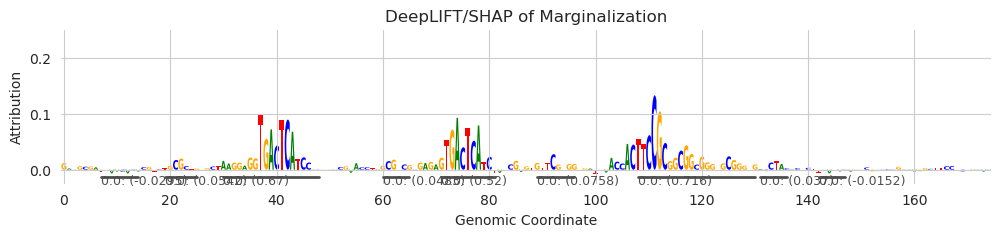

In [6]:
seqlets = recursive_seqlets(X_attr.sum(dim=1), threshold=0.1)

plt.figure(figsize=(12, 2))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=925, end=1100, annotations=seqlets, score_key='attribution')
plt.ylim(-0.025, 0.25)

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

Looks like the main seqlets are basically being discovered again but that some of the other small spans of modest attribution characters are also being picked up as seqlets. Depending on how clean your data is, this may be desirable, but also could be noise. Ultimately, seqlet calling in one pass like this is very challenging to do without any additional information.

##### TF-MoDISco Seqlets

TF-MoDISco is an algorithm for identifying repeating seqlet patterns. The first step in this algorithm is to call seqlets. Accordingly, it uses an approach that is somewhat similar to the recursive algorithm in that it defines a background distribution for positive and negative seqlets separately, but it has several more steps that are meant to be helpful in the final goal of finding repeating patterns. For instance, this seqlet calling method will first smooth the attribution values, uses a wide fixed window, and fits isotonic regressions to estimate background probabilities instead of the binning strategy employed by the recursive algorithm. Although the seqlet calls from this algorithm are also done using a greedy procedure, the recursive seqlet property does not hold for the seqlets called here.

We can run this seqlet calling method using the `tfmodisco_seqlets` function. This function takes in an attribution track -- which should not contain hypothetical attributions -- and returns a set of seqlets with positive attribution and a set of seqlets with negative attributions as pandas DataFrames with the same format as the other motif calling methods.

In [7]:
from tangermeme.seqlet import tfmodisco_seqlets

seqlets = tfmodisco_seqlets(X_attr.sum(dim=1))
print(seqlets.shape)
seqlets.head()

(19, 4)


,example_idx,start,end,attribution
0,0,1021,1062,0.788878
1,0,941,982,0.685255
2,0,975,1016,0.623512
3,0,1000,1041,0.146656
4,0,885,926,0.128889


It looks like the attribution scores drop significantly after the third seqlet. This is likely because the first three seqlets correspond to the three known motifs that we inserted into the sequence and the ones after that are just false positives. Something to note about this approach to seqlet calling is that it assumes a minimum number of regions will be seqlets and so will adaptively change the thresholds internally to make sure that number of seqlets are called. This means that the method can overcall seqlets when examples do not have enough going on in them. Here, we can see that 19 seqlets are called, in comparison to just 5 when using the recursive seqlet caller. For TF-MoDISco, overcalling seqlets is not a big problem because the seqlets are more rigorously filtered in subsequent steps, but you may need to implement similar filtering (e.g., based on attribution scores) to remove these spuriously called seqlets from your downstream analyses.

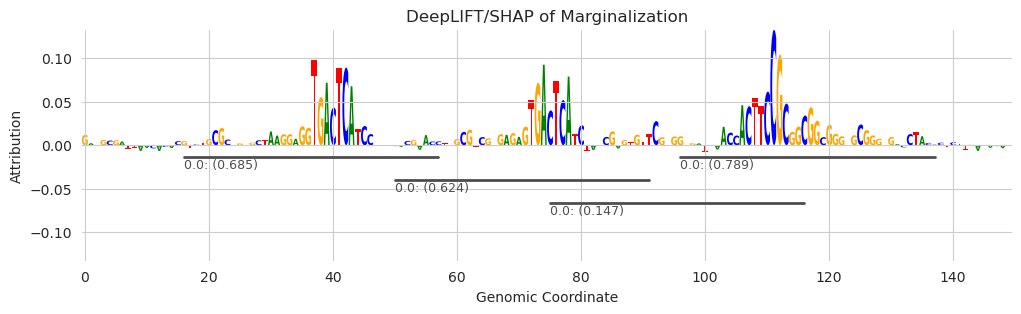

In [8]:
plt.figure(figsize=(12, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=925, end=1075, annotations=seqlets, score_key="attribution")

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

Looks like all three of the motifs we added in are being underlined by the seqlet caller. Similar to the recursive seqlet caller, the TF-MoDISco seqlet caller will first identify core components of seqlets that cannot overlap and then subsequently expand the boundaries in a way that can overlap with other seqlets. The difference here is just that TF-MoDISco will expand out the flanks by default because that is useful for the subsequent clustering algorithm -- i.e., the seqlet calling algorithm is purpose-driven for the rest of the algorithm, rather than being general-purpose.

You might notice that the boundaries seem a little bit... offset... with a longer span to the left of the seqlet than to the right. This is because, internally, the attribution at each position is replaced with the sum of the attributions starting at that position and moving to the right. This means that the chosen position for each seqlet is the left side of the seqlet. From this chosen position, a fixed-width span is chosen on either end as the seqlet boundaries.

By default, the TF-MoDISco seqlet caller calls seqlets that are quite long. This is because the subsequent TF-MoDISco pattern discovery algorithm uses a similarity score based on alignment and so it is better for the seqlets to have longer context and make sure to capture everything than it is to miss something important in the seqlet. If you would like to change the width you can alter the `window_size` and `flank` arguments. The `window_size` argument defines how many positions to the right to sum over when replacing the position-specific attribution, and the `flank` argument defines the additional number of nucleotides to add to the seqlet for padding.

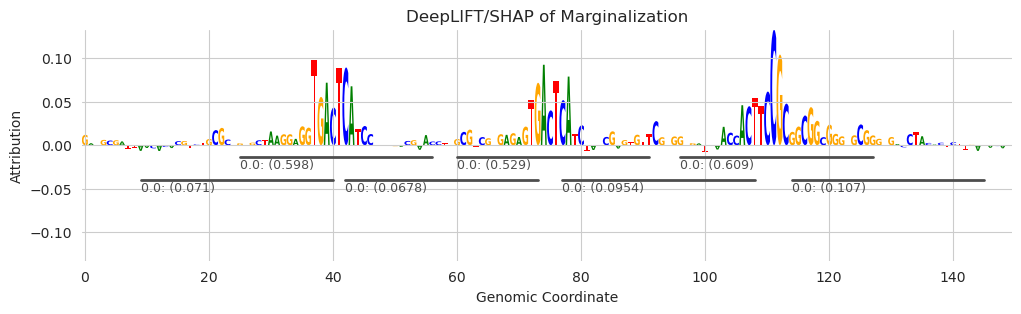

In [9]:
seqlets = tfmodisco_seqlets(X_attr.sum(dim=1), window_size=11)

plt.figure(figsize=(12, 3))
ax = plt.subplot(111)
plot_logo(X_attr[0], ax=ax, start=925, end=1075, annotations=seqlets, score_key="attribution")

plt.xlabel("Genomic Coordinate")
plt.ylabel("Attribution")
plt.title("DeepLIFT/SHAP of Marginalization")
plt.show()

By decreasing the window size to 11 we get shorter seqlets but also we begin to get an overcalling of low-attribution seqlets. This is largely because, when a seqlet is called, a window surrounding the calling position is blanked out, preventing additional seqlets from being called at this position. When the window size is decreased, additional seqlets may be called that pick up on the flanking nucleotides that do not themselves have very high attribution scores but have relatively high attributions given a background sequence. However, the seqlets called for the known patterns are still several times stronger than any of the overcalled seqlets.

Taken together, seqlet calling and plotting of these annotations can be a powerful tool for understanding what your model is picking up on when it makes predictions. As we will see in later notebooks, the automatic partitioning of the genome into units that drive predictions will be a valuable step for many downstream processes that can be useful in summarizing the features driving predictions globally.